# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that we've discussed some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, yoiu will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modelling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. We've discussed the bias variance tradeoff, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modelling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('loan_final.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.2+ MB


In [2]:
data = data.dropna()
data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


## Defining the Problem

Set up the problem by defining X and Y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Be sure to use dummy variables for categorical variables and to normalize numerical quanitities. Be sure to also remove any rows with null data.  

For Y, we are looking to build a model to predict the total payment received for a loan.

In [3]:
for i in range(len(data.columns)):
    print(f'{i}. {data.columns[i]}')

0. loan_amnt
1. funded_amnt_inv
2. term
3. int_rate
4. installment
5. grade
6. emp_length
7. home_ownership
8. annual_inc
9. verification_status
10. loan_status
11. purpose
12. addr_state
13. total_acc
14. total_pymnt
15. application_type


In [18]:
X_init = data.iloc[:, [0, 7, 1, 9, 6, 4, 8]]
X_dict = {}

for col in X_init.columns:
    
    if X_init[col].dtype != np.number:
        X_dict[col] = pd.get_dummies(X_init[col])
        
    elif (max(X_init[col]) == 1) and (min(X_init[col]) == 0):
        X_dict[col] = X_init[col]
        
    else:
        X_dict[col] = (X_init[col] - np.mean(X_init[col])) / np.std(X_init[col])
        
X = pd.concat([X_dict[key] for key in X_dict.keys()], axis=1)
print(X.shape)
X.head()

(41394, 23)


,loan_amnt,MORTGAGE,NONE,OTHER,OWN,RENT,funded_amnt_inv,Not Verified,Source Verified,Verified,...,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year,installment,annual_inc
0,-0.831064,0,0,0,0,1,-0.731196,0,0,1,...,0,0,0,0,0,0,0,0,-0.774545,-0.708860
1,-1.168176,0,0,0,0,1,-1.077707,0,1,0,...,0,0,0,0,0,0,0,1,-1.267125,-0.615909
2,-1.181661,0,0,0,0,1,-1.091707,1,0,0,...,0,0,0,0,0,0,0,0,-1.150003,-0.890856
3,-0.156841,0,0,0,0,1,-0.027675,0,1,0,...,0,0,0,0,0,0,0,0,0.068920,-0.318468
4,-1.100754,0,0,0,0,1,-1.007705,0,1,0,...,0,0,0,0,0,0,0,0,-1.229072,0.158677


In [19]:
Y = data['total_pymnt']
Y = (Y - np.mean(Y)) / np.std(Y)

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modelling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=.1, 
                                                    random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37254, 23) (4140, 23) (37254,) (4140,)


## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. Be sure your function returns performance metrics regarding the training and validation sets.

In [25]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model.   

In general, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. We set up a k-folds cross-validation for this task since the dataset is not overly large.  

Build an initial sequential model with 2 hidden relu layers. The first should have 7 hidden units, and the second 10 hidden units. Finally, add a third layer with a linear activation function to output our predictions for the total loan payment. 

In [26]:
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(123)
model = Sequential([Dense(7, input_shape=(23, ), activation='relu'), 
                    Dense(10, activation='relu'), 
                    Dense(1, activation='linear')])

model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

Instructions for updating:
Use tf.cast instead.
3725/3725 [==============================] - 0s 8us/step
Mean Validation Score: 0.18826586529392947
Standard Deviation of Validation Scores: 0.012076463874340474
Time Elapsed: 0:09:38.269811


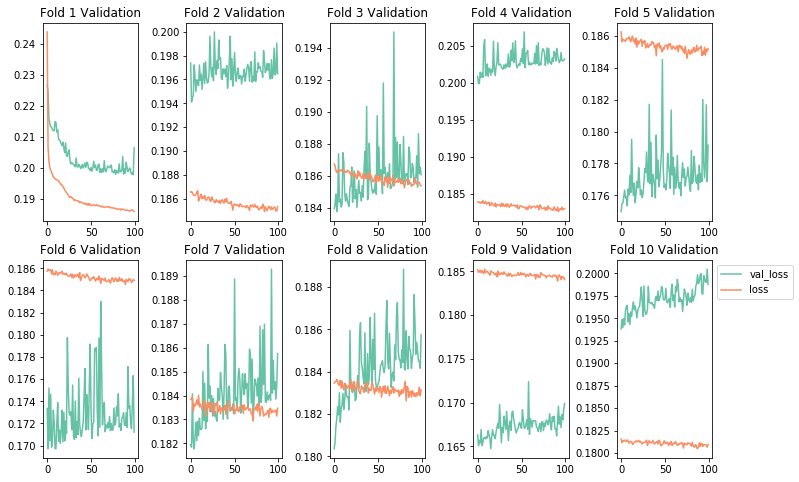

In [27]:
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.  

For example, here are some timing notes on potential experiments run on a Macbook Pro 3.1 GHz Intel Core i5 with 16gb of RAM:

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 100 epochs took approximately 15 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 25 units per hidden layer and 100 epochs took approximately 25 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 250 epochs took approximately 45 minutes to train and validate


3725/3725 [==============================] - 0s 10us/step
Mean Validation Score: 0.18756440097152063
Standard Deviation of Validation Scores: 0.008585975641021742
Time Elapsed: 0:11:01.408446


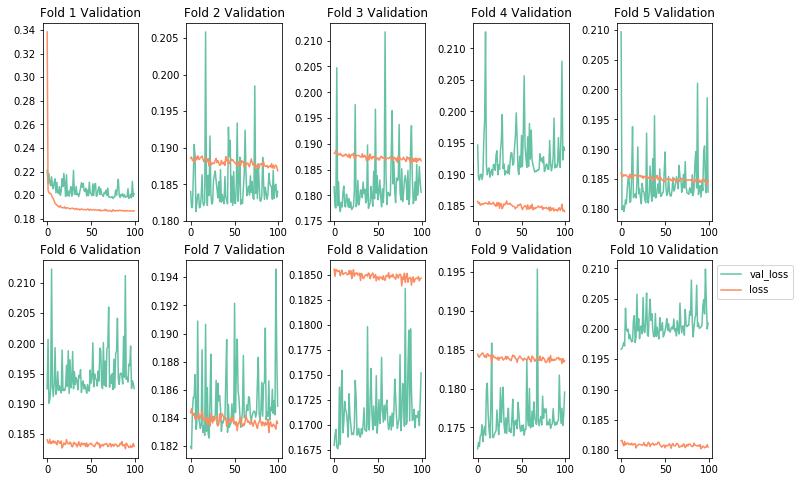

In [29]:
now = datetime.datetime.now()

#Model Mod 1: Adding More Layers
model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 10us/step
Mean Validation Score: 0.18601600666767584
Standard Deviation of Validation Scores: 0.01388119338736321
Time Elapsed: 0:10:58.135877


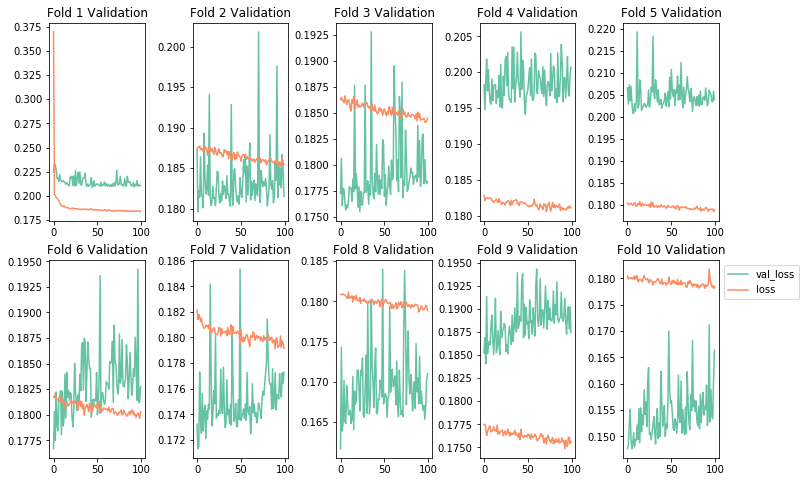

In [30]:
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 11us/step
Mean Validation Score: 0.18618198466996705
Standard Deviation of Validation Scores: 0.010187311686484542
Time Elapsed: 0:27:31.507489


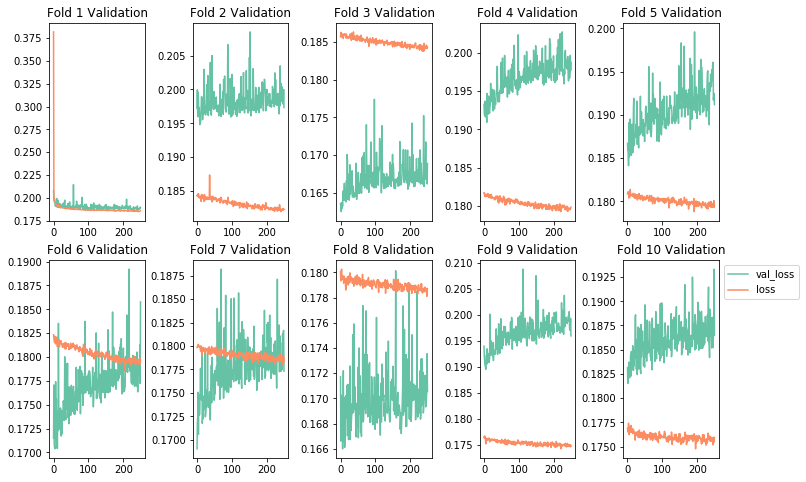

In [31]:
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=250)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3725/3725 [==============================] - 0s 10us/step
Mean Validation Score: 0.19713389876061022
Standard Deviation of Validation Scores: 0.006669501639688611
Time Elapsed: 0:08:52.163305


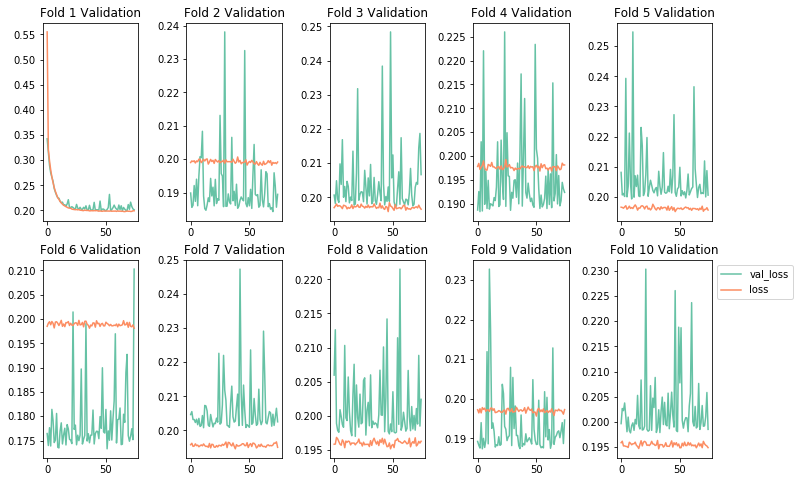

In [32]:
from keras import regularizers

now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
3725/3725 [==============================] - 0s 12us/step
Mean Validation Score: 0.23200371007827725
Standard Deviation of Validation Scores: 0.010641089038857925
Time Elapsed: 0:10:03.680239


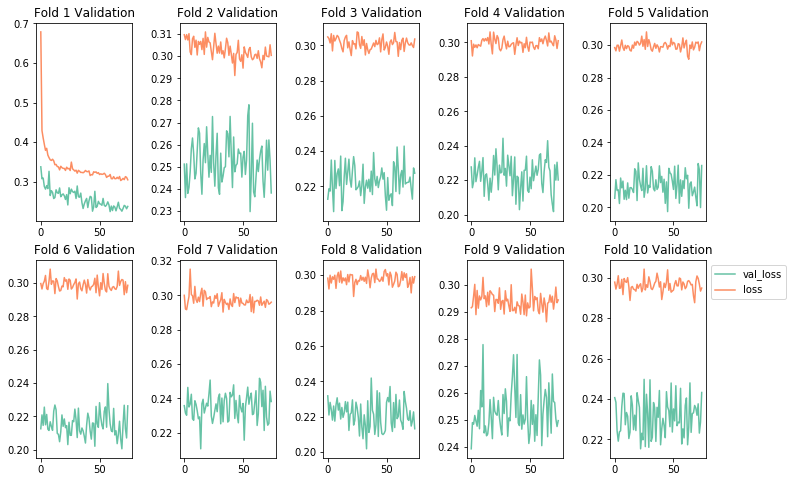

In [33]:
from keras import layers

now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 12us/step
Mean Validation Score: 0.32459149269971793
Standard Deviation of Validation Scores: 0.044822935818000856
Time Elapsed: 0:10:38.782112


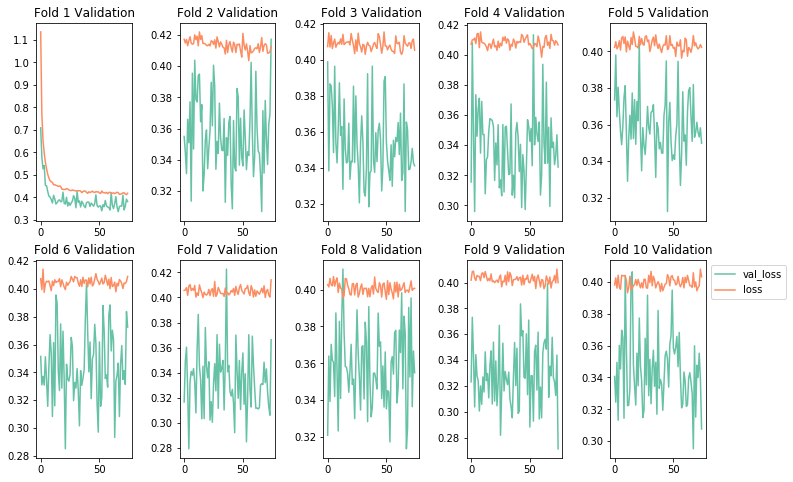

In [34]:
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
#Your code here; try some regularization or other methods to tune your network

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your expirements above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modelling process)!

In [35]:
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/75
37254/37254 [==============================] - 1s 36us/step - loss: 0.6003 - mean_squared_error: 0.4695
Epoch 2/75
37254/37254 [==============================] - 1s 23us/step - loss: 0.3126 - mean_squared_error: 0.2054
Epoch 3/75
37254/37254 [==============================] - 1s 26us/step - loss: 0.2898 - mean_squared_error: 0.2030
Epoch 4/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2732 - mean_squared_error: 0.2026
Epoch 5/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.2605 - mean_squared_error: 0.2028
Epoch 6/75
37254/37254 [==============================] - 1s 23us/step - loss: 0.2494 - mean_squared_error: 0.2017
Epoch 7/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.2409 - mean_squared_error: 0.2013
Epoch 8/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2347 - mean_squared_error: 0.2014
Epoch 9/75
37254/37254 [==============================] - 1s 24us/step - loss: 0

In [36]:
model.evaluate(X_test, y_test)

4140/4140 [==============================] - 0s 38us/step


[0.18938897584659467, 0.18193907750689464]

## Additional Resources

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
https://www.springboard.com/blog/free-public-data-sets-data-science-project/

## Summary

In this lab, we investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. We began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, we implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, we'll begin to investigate other neural network architectures such as CNNs.